In [109]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats as sts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import os

In [3]:
BASE_NAME = 'monthly-australian-wine-sales.csv'
BASE_PATH = '/mnt/sda/Yandex.Disk/temp/bases'
FILE_PATH = os.path.join(BASE_PATH, BASE_NAME)
os.path.isfile(FILE_PATH)

True

In [4]:
df = pd.read_csv(
    FILE_PATH, index_col='month', 
    parse_dates=['month'], dayfirst=True
)
df.head()

,sales
month,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


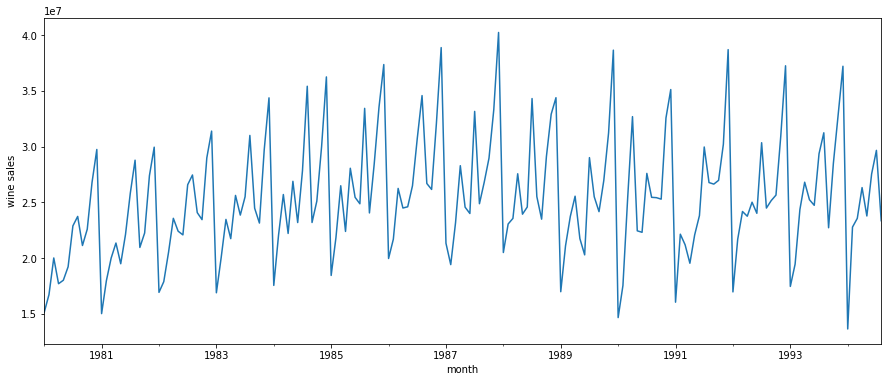

In [5]:
df.sales = df.sales*1000
plt.figure(figsize=(15, 6))
df.sales.plot()
plt.xlabel('month')
plt.ylabel('wine sales')
plt.show()

Сильно выраженная годовая сезонность. Похоже есть тренд. Размах колебаний вначале ряда меньше, чем в середине и конце ряда.

### Проверка стационарности и STL-декомпозиции

#### Критерий Дики-Фуллера:
$
y^T = y_1, ..., y_T \\
H_0: \text{ряд нестационарен} \\
H_1: \text{ряд стационарен} \\
F_0: \text{табличное}
$

Критерий Дики-Фулера: 0.0512


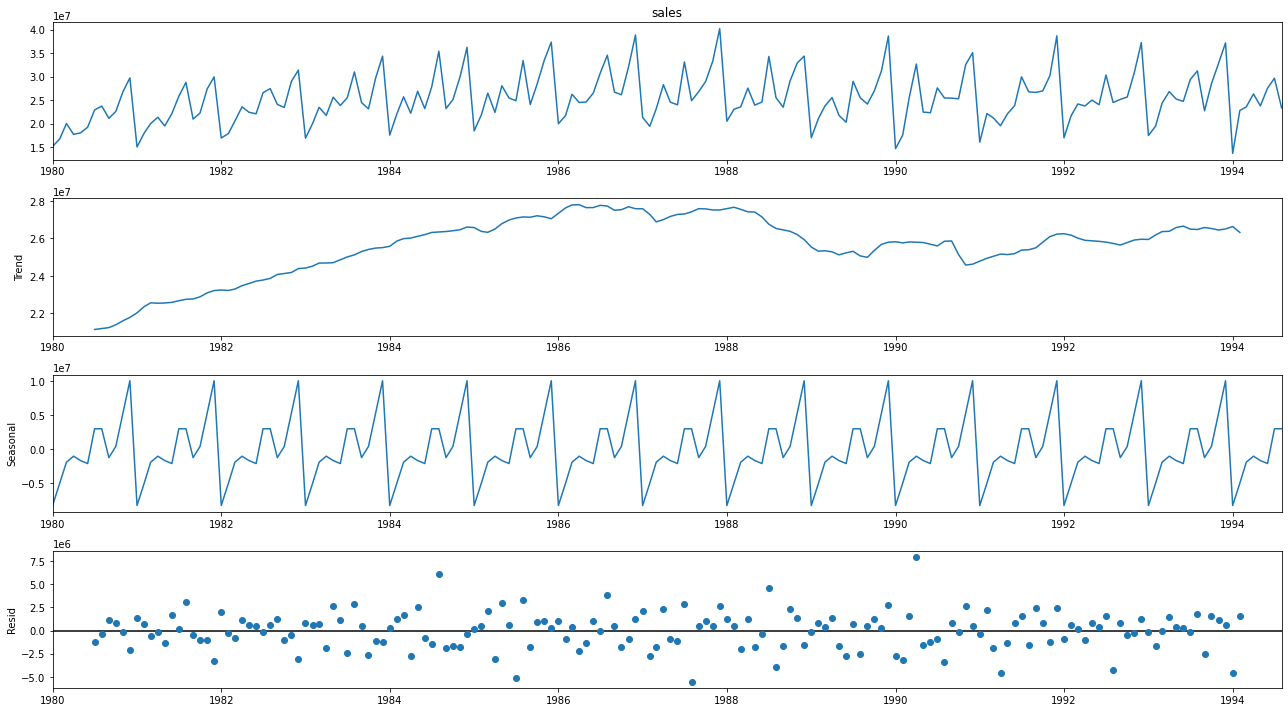

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
sm.tsa.seasonal_decompose(df.sales).plot()
DFC = sm.tsa.stattools.adfuller(df.sales)[1].round(4)
txt = f'Критерий Дики-Фулера: {DFC}'
print(txt)
plt.show()

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

$
\begin{equation*}
 y_t^{'} = 
     \begin{cases}
       \textbf {ln}\; y_t,                 \;\;\;\;\;\;\;\; \lambda=0 \\
       (y_t^\lambda-1)/\lambda, \;\; \lambda \neq 0
     \end{cases}
\end{equation*}
$

In [2]:
# inverse of Box-Cox transformation
def invboxcox(y, lmb):
    if lmb == 0:
        return(np.exp(y))
    else:
        return np.exp(np.log(lmb*y+1)/lmb)

Критерий Дики-Фулера: 0.0296


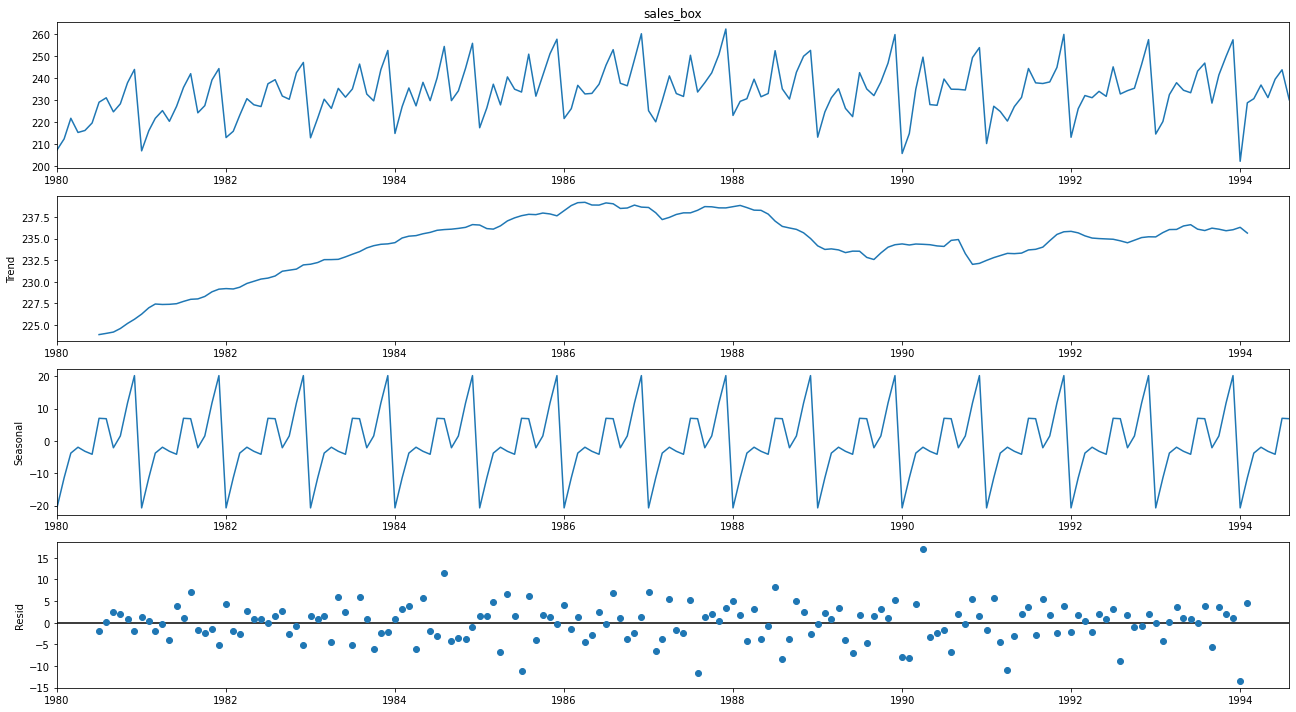

In [7]:
df['sales_box'], lmb = sts.boxcox(df.sales)
sm.tsa.seasonal_decompose(df.sales_box).plot()
DFC = sm.tsa.stattools.adfuller(df.sales_box)[1].round(4)
txt = f'Критерий Дики-Фулера: {DFC}'
print(txt)
plt.show()

Согласно критерию Дики-Фулера ряд стационарный (гипотеза о нестационарности отвергается). Однако стационарным его считать нельзя т.к. виден тренд и видна сезонность.

### Диффиренцирование ряда 
переход к попарным разностям соседних значений:
$$y_t{'} = y_t - y_{t-1} \notag$$
- стабилизация среднего значения, избавление от тренда

#### Сезонное дифференцирования
переход к попарным разностям значений в соседних сезонах: 
$$y_t{'} = y_t - y_{t-s} \notag$$
- убирает сезонность

Критерий Дики-Фулера: 0.1283


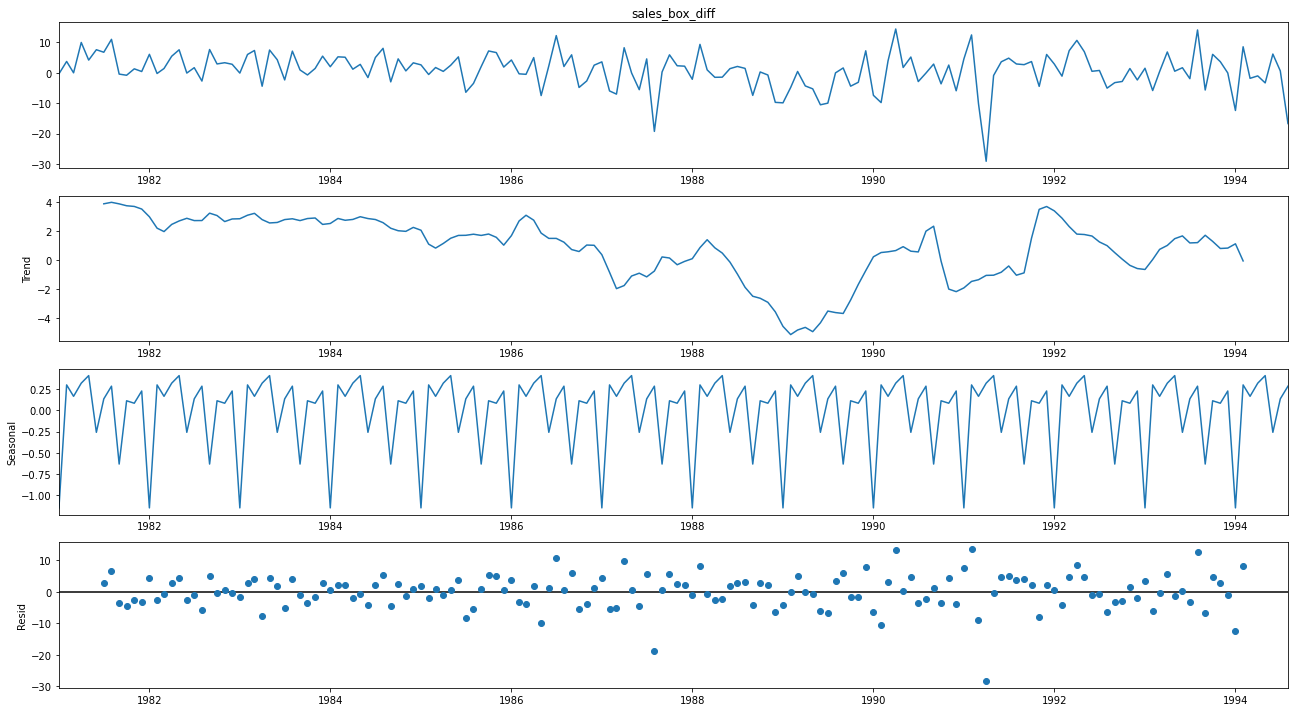

In [8]:
df['sales_box_diff'] = df.sales_box - df.sales_box.shift(12)
sm.tsa.seasonal_decompose(df.sales_box_diff[12:]).plot()
DFC = sm.tsa.stattools.adfuller(df.sales_box_diff[12:])[1].round(4)
txt = f'Критерий Дики-Фулера: {DFC}'
print(txt)
plt.show()

Критерий Дики-Фулера: 2e-06


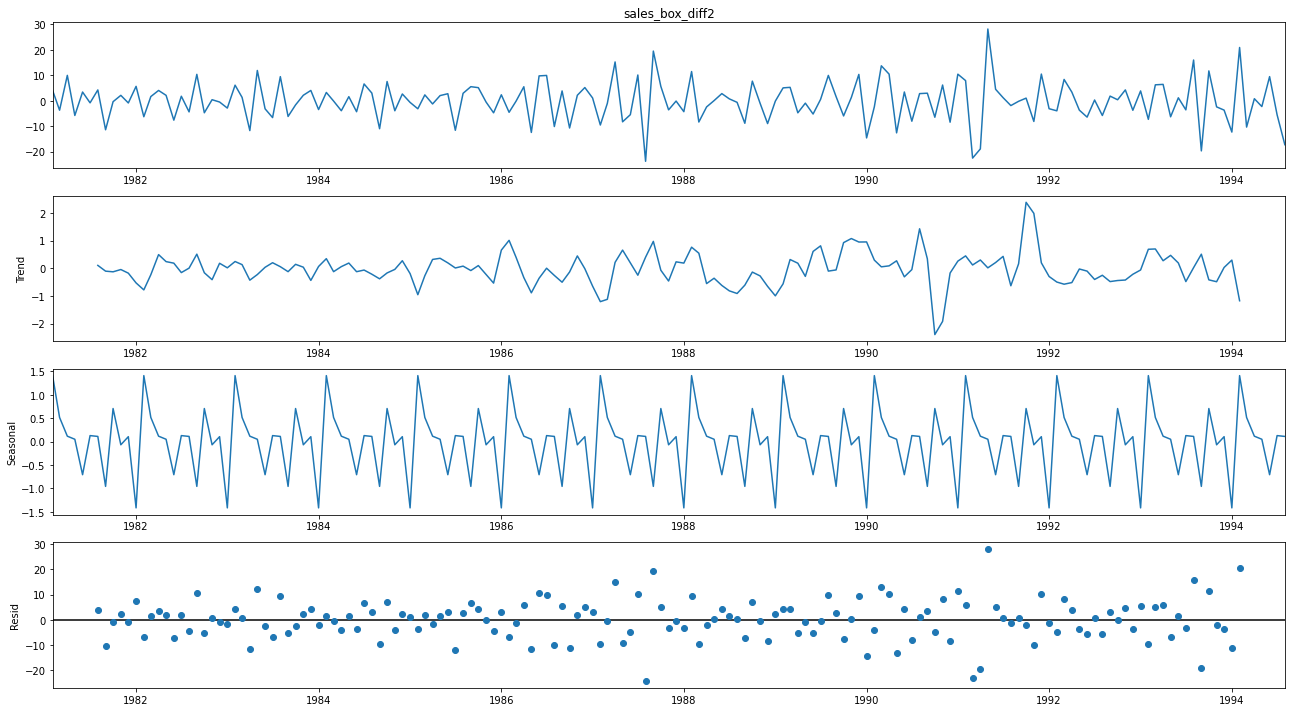

In [9]:
df['sales_box_diff2'] = df.sales_box_diff - df.sales_box_diff.shift(1)
sm.tsa.seasonal_decompose(df.sales_box_diff2[13:]).plot()
DFC = sm.tsa.stattools.adfuller(df.sales_box_diff2[13:])[1].round(6)
txt = f'Критерий Дики-Фулера: {DFC}'
print(txt)
plt.show()

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше - тренда больше нет.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

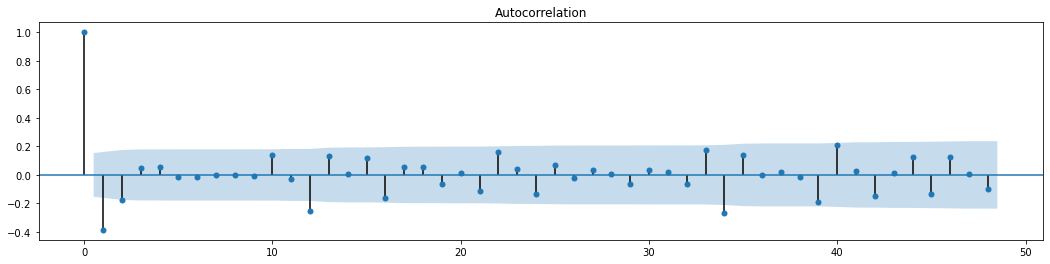

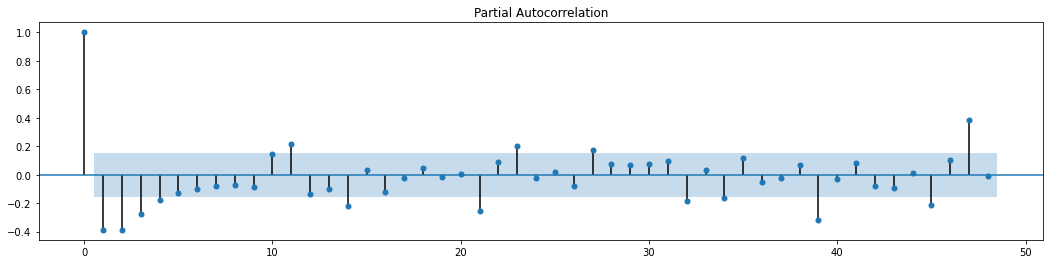

In [11]:
rcParams['figure.figsize'] = 18, 4
sm.graphics.tsa.plot_acf(df.sales_box_diff2[13:].values,lags=48)
sm.graphics.tsa.plot_pacf(df.sales_box_diff2[13:].values,lags=48)
plt.show()

Начальные приближения: Q=1, q =2, P=1, p=4;
Q*S - максимальный сезонный лаг значимо отличающийся от нуля на АС равен 12;
q - максимальный лаг значимо отличающийся от нуля на АС равен 2;
P*S - максимальный сезонный лаг значимо отличающийся от нуля на PАС равен 12;
q - максимальный лаг значимо отличающийся от нуля на PАС равен 4.

In [20]:
ps = range(0, 5)
d = 1
qs = range(0, 3)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [33]:
%%time
result = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:

    try:
        model = sm.tsa.statespace.SARIMAX(
            df.sales_box, 
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
    
    result.append([param, model.aic])

warnings.filterwarnings('default')

CPU times: user 2min 51s, sys: 10.6 s, total: 3min 2s
Wall time: 3min 19s


In [37]:
result_table = pd.DataFrame(result)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).round(2).head()

,parameters,aic
29,"(2, 1, 0, 1)",1007.80
31,"(2, 1, 1, 1)",1008.79
45,"(3, 2, 0, 1)",1009.17
33,"(2, 2, 0, 1)",1009.28
41,"(3, 1, 0, 1)",1009.72


Лучшая модель с минимальным значением информационного критерия Акаике:

In [39]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -498.901
Date:                            Sun, 04 Jul 2021   AIC                           1007.801
Time:                                    18:12:03   BIC                           1023.270
Sample:                                01-01-1980   HQIC                          1014.082
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111     -1.800      0.072      -0.416       0.018
ma.L1         -0.8394      0.055    -15.258      0.000      -0.947      -0.732
ma.S.L12      -0.6688      0.052    -12.746      0.000      -0.772      -0.566
sigma2        25.2277      2.144     11.768      0.000      21.026      29.429
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                25.57
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Q-тест Льюнга - Бокса - (0.01, 0.93) - данные являются случайными (белый шум, неавтокоррелированы).

#### Визуальный анализ остатков лучшей модели

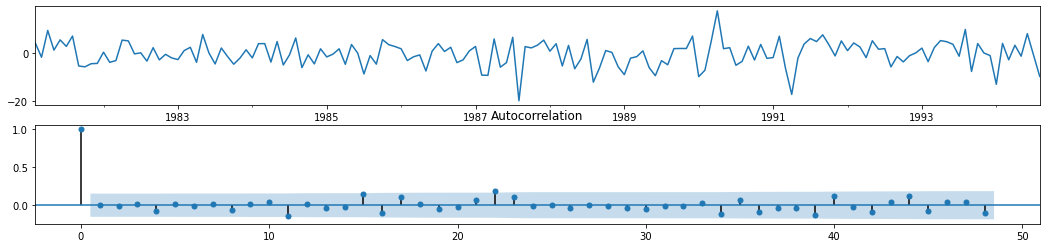

Критерий Дики-Фулера: 1.8444655664515945e-23
Критерий Стьюдента: 0.258


In [68]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 4))
best_model.resid[13:].plot(ax=axes[0])
sm.graphics.tsa.plot_acf(best_model.resid[13:].values, lags=48, ax=axes[1])
plt.show()

DFC = sm.tsa.stattools.adfuller(best_model.resid[13:])[1]
txt = f'Критерий Дики-Фулера: {DFC}'
print(txt)
SC = sts.ttest_1samp(best_model.resid[13:], 0)[1]
txt = f'Критерий Стьюдента: {SC.round(3)}'
print(txt)

Остатки несмещены (кр. Стьюдента), стационарны (кр. Д-Ф, визуально), неавткоррелированы (Льюнга-Бокса и коррелограммой).

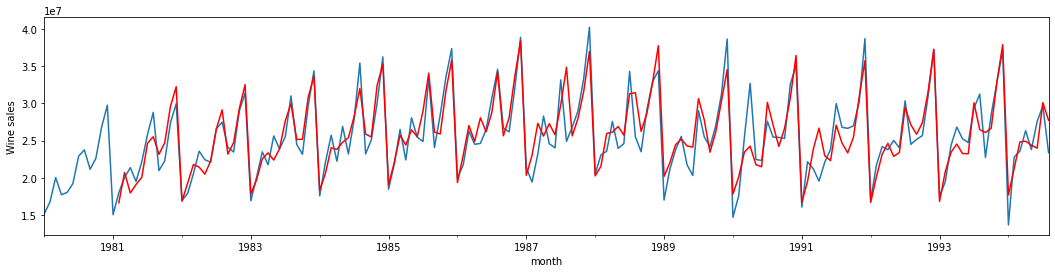

In [73]:
df['model'] = invboxcox(best_model.fittedvalues, lmb)
df.sales.plot()
df.model[13:].plot(color='r')
plt.ylabel('Wine sales')
plt.show()

### Прогноз

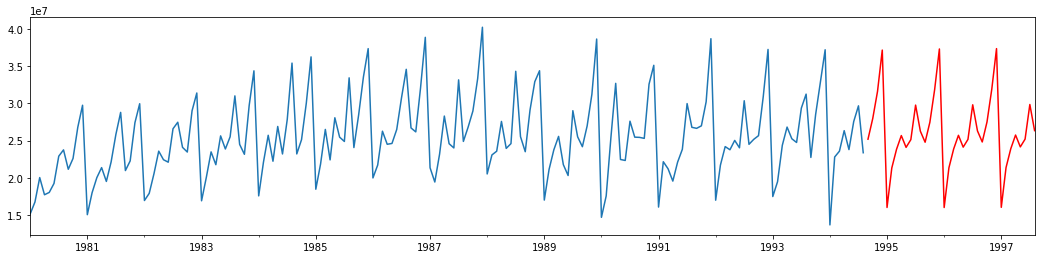

In [147]:
df2 = df[['sales']].copy()
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") 
             + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=df.columns)
df2 = pd.concat([df2, future])

df2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmb)
df2.sales.plot()
df2.forecast.plot(color='r')
plt.show()

В предсказании также видна сезнность ряда и в нем нет тренда. Поскольку тренд на обучении имел сложную структуру и в момент, когда необходимо было сделать предсказание модель не смогла определить тренд (направление тренда).